In [1]:
import torch
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from IPython.display import display
from concurrent.futures import ProcessPoolExecutor

In [ ]:
DS = Path("../dataset/processed/frames")

In [3]:
def process_image(img_path):
        img = cv.imread(str(img_path))
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        h, w = img.shape[:2]
        return {
            "aspect_ratio": round(w / h, 2),
            "brightness": cv.norm(gray, cv.NORM_L2) / (h * w),
            "blurriness": cv.Laplacian(gray, cv.CV_64F).var()
        }

In [4]:
def analyze_dataset(DS: Path):
    frame_data = {}

    def process_subject(subj_path, split):
        frames = list((subj_path / "fv").rglob("*.jpg"))
        frame_count = len(frames)

        with ProcessPoolExecutor() as executor:
            results = list(executor.map(process_image, frames))

        valid_results = [r for r in results if r]

        aspect_ratios = [r["aspect_ratio"] for r in valid_results]
        brightness_values = [r["brightness"] for r in valid_results]
        blurriness_scores = [r["blurriness"] for r in valid_results]

        subj_name = subj_path.name
        frame_data.setdefault(subj_name, {"Train": 0, "Val": 0, "Test": 0, "Corrupt": frame_count - len(valid_results)})
        frame_data[subj_name][split.capitalize()] = frame_count

        if aspect_ratios:
            frame_data[subj_name].update({
                "Min Res": min(aspect_ratios),
                "Max Res": max(aspect_ratios),
                "Avg Res": round(np.mean(aspect_ratios), 2),
                "Aspect Ratio": max(set(aspect_ratios), key=aspect_ratios.count),
                "Avg Brightness": round(np.mean(brightness_values), 2),
                "Avg Blurriness": round(np.mean(blurriness_scores), 2)
            })

    for split in ["train", "val", "test"]:
        for subject in (DS / split).iterdir():
            if subject.is_dir():
                process_subject(subject, split)

    df = pd.DataFrame.from_dict(frame_data, orient="index").reset_index().rename(columns={"index": "Subject"})
    df["Total"] = df[["Train", "Val", "Test"]].sum(axis=1)

    total_row = pd.DataFrame([df.sum(numeric_only=True).to_dict()])
    total_row["Subject"] = "TOTAL"
    df = pd.concat([df, total_row], ignore_index=True)

    display(df)
    return df

In [5]:
df = analyze_dataset(DS)

,Subject,Train,Val,Test,Corrupt,Min Res,Max Res,Avg Res,Aspect Ratio,Avg Brightness,Avg Blurriness,Total
0,s001,4080.0,780.0,720.0,0.0,1.78,1.78,1.78,1.78,0.1,127.88,5580.0
1,s002,3720.0,960.0,900.0,0.0,1.78,1.78,1.78,1.78,0.1,125.44,5580.0
2,TOTAL,7800.0,1740.0,1620.0,0.0,3.56,3.56,3.56,3.56,0.2,253.32,11160.0


In [6]:
frames = "/home/lucban/cc_all/dataset/processed/frames/train/s002/fv/uni/s002_uni1_fv_cp_wb_v2/frame_0040.jpg"
frame = Image.open(frames)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=True, device=device, thresholds=[0.85, 0.9, 0.9])

boxes, probs = mtcnn.detect(frame)

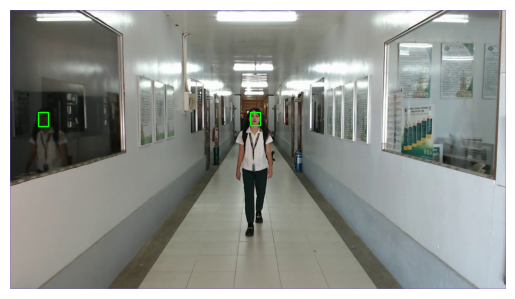

In [7]:
plt.imshow(frame)
if boxes is not None:
    for box in boxes:
        x, y, w, h = box
        plt.gca().add_patch(plt.Rectangle((x, y), w-x, h-y, edgecolor='lime', linewidth=1, fill=False))

plt.axis("off")
plt.show()

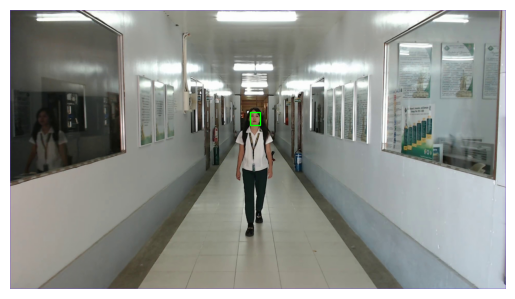

In [ ]:
valid = []
if boxes is not None:
    for box, prob in zip(boxes, probs):
        if prob >= 0.95:  
            x1, y1, x2, y2 = map(int, box)
            face = frame.crop((x1, y1, x2, y2)).convert("L")
            brightness = np.array(face).mean()

            if brightness >= 40:
                valid.append((box, prob, brightness))

plt.imshow(frame)
plt.gca().add_patch(plt.Rectangle((x, y), w-x, h-y, edgecolor='lime', linewidth=1, fill=False))

plt.axis("off")
plt.show()